In [2]:
from cells import layer_v_with_ais_test 
from neuron import h, gui
from helpers.record import *
import numpy as np
import copy
from importlib import reload
from helpers.rheobase import *
from helpers.generic import isolateTime, plotTrace
from helpers.stimulation import *

reload(layer_v_with_ais_test )
cell = layer_v_with_ais_test.SPI6()

# Ap Properties Experiment

This Rheobase Experiment Plots every result with its according cure

In [3]:
reload(layer_v_with_ais_test)

over, under = calculateRheobase(layer_v_with_ais_test.SPI6)

undertrace = stimulate(layer_v_with_ais_test.SPI6, under)
overtrace = stimulate(layer_v_with_ais_test.SPI6, over)

Intial guess -0.2
Running in range  0.6000000000000001 from  -0.2 to  0.4000000000000001
Detected first AP at 0.10000000000000003  [mv]
Intial guess 0.10000000000000003
Running in range  0.03000000000000001 from  0.07000000000000002 to  0.13000000000000003
Detected first AP at 0.09700000000000003  [mv]
Intial guess 0.09700000000000003
Running in range  0.002910000000000001 from  0.09409000000000003 to  0.09991000000000003
Detected first AP at 0.09612700000000003  [mv]


# Plot

Plotting the Results

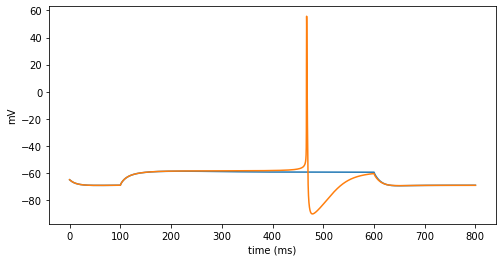

In [119]:
from helpers import generic
reload(generic)
generic.plotTraces([undertrace,overtrace])

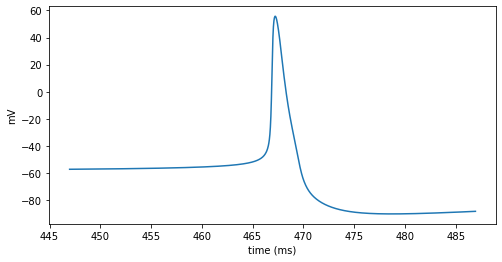

In [158]:

firstpeaktime = overtrace["aps"][0]
newtrace = generic.isolateTime(overtrace, firstpeaktime, 20)
generic.plotTrace(newtrace)


# First Derivative

Calculating the Rheobase through iterating until first action potential is generated, This looks like it is wrong

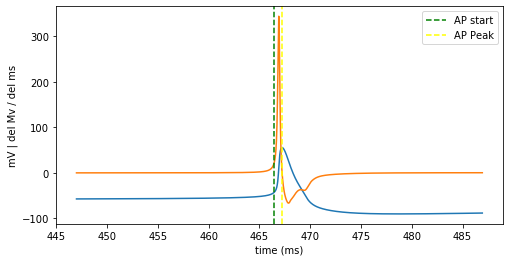

In [164]:
def find_first_nearest_index_for_value(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx


def calculateAPThresholdAndDerivative(tracein):
    ''' Finds the first AP in a trace and checks for its Properties'''
    copytrace = copy.copy(tracein)
    time = copytrace["t"].max() - copytrace["t"].min()
    hertz = copytrace["t"].shape[0]/time
    dT = 1/hertz

    gradient = np.gradient(copytrace["v"],dT) # Is this correct?
    over = gradient > 20
    apstart = np.argmax(over)
    
    if over[apstart] == False: 
        print("ERROR: No AP detected")
        return False
    
    apstarttime = generic.frametotime(copytrace["t"], apstart)
    apstartvalue = copytrace["v"][apstart]
    
    
    # Cutting the Trace to begin with the AP
    apVtrace = copytrace["v"][apstart:]
    apTtrace = copytrace["t"][apstart:]
    
    
    
    # Finding the First Peak after the Threshold
    peakindex = np.argmax(apVtrace)
    peaktime = generic.frametotime(apTtrace, peakindex)
    peakValue = apVtrace[peakindex]
    
    # Finding the Max Slop in between the APStart and the Peak
    slopeV = apVtrace[:peakindex]
    slopeT = apVtrace[:peakindex]
    slopeVgradient = np.gradient(slopeV,dT)
    maxslopeindex = np.argmax(slopeVgradient)
    maxslopetime = generic.frametotime(slopeT, maxslopeindex)
    maxslopevalue = slopeVgradient[maxslopeindex]
    
    # Finding the first Dump after the Peak
    apAfterPeakVtrace = apVtrace[peakindex:]
    apAfterPeakTtrace = apTtrace[peakindex:]
    apAfterPeakGradient = np.gradient(apAfterPeakVtrace,dT)
    zero_crossings = np.where(np.diff(np.sign(apAfterPeakGradient)))[0]
 
    hypermaxindex = zero_crossings[0]
    hypermaxtime = generic.frametotime(apAfterPeakTtrace, hypermaxindex)
    hypermaxvalue = apAfterPeakVtrace[hypermaxindex]
    
    

    # Set parameter of ouput
    trace = copytrace
    trace["v/t"] = gradient
    trace["firstOver20Time"] = apstarttime
    trace["firstOver20Value"] = apstartvalue
    trace["peakTime"] = peaktime
    trace["riseTime"] = peaktime - apstarttime
    trace["peakValue"] = peakValue
    trace["APRiseTime"] = peaktime - apstarttime
    trace["maxSlopeTime"] = maxslopetime
    trace["maxSlopeValue"] = maxslopevalue
    trace["hyperMaxTime"] = hypermaxtime
    trace["hyperMaxValue"] = hypermaxvalue
    trace["Ap AHP"] =  apstartvalue - hypermaxvalue
    trace["AP MaxSlope"] = maxslopevalue
    
    
    middleAPValue = apstartvalue + (peakValue - apstartvalue)/2
    tenPercentAPValue = apstartvalue + (peakValue - apstartvalue)/10
    ninetyPercentAPValue = apstartvalue + 9*(peakValue - apstartvalue)/10
    

    firstIndexClosestToMiddleApValue= find_first_nearest_index_for_value(apVtrace[:peakindex],middleAPValue)
    firstIndexClosestToTenPercentApValue= find_first_nearest_index_for_value(apVtrace[:peakindex],tenPercentAPValue)
    firstIndexClosestToNinetyPercentValue= find_first_nearest_index_for_value(apVtrace[:peakindex],ninetyPercentAPValue)
    secondIndexClosestToMiddleApValue = find_first_nearest_index_for_value(apVtrace[peakindex:],middleAPValue)
    secondIndexClosestToTenPercentApValue = find_first_nearest_index_for_value(apVtrace[peakindex:],tenPercentAPValue)
    secondIndexClosestToNinetyPercentApValue = find_first_nearest_index_for_value(apVtrace[peakindex:],ninetyPercentAPValue)
    
    midApUpTime = generic.frametotime(apTtrace[:peakindex], firstIndexClosestToMiddleApValue)
    midApDownTime =  generic.frametotime(apTtrace[peakindex:], secondIndexClosestToMiddleApValue)
    midApUpValue = apVtrace[:peakindex][firstIndexClosestToMiddleApValue]
    midApDownValue = apVtrace[peakindex:][secondIndexClosestToMiddleApValue]
    
    tenPercentUpTime = generic.frametotime(apTtrace[:peakindex], firstIndexClosestToTenPercentApValue)
    tenPercentDownTime = generic.frametotime(apTtrace[peakindex:], secondIndexClosestToTenPercentApValue)
    ninetyPercentUpTime = generic.frametotime(apTtrace[:peakindex], firstIndexClosestToNinetyPercentValue)
    ninetyPercentDownTime = generic.frametotime(apTtrace[peakindex:], secondIndexClosestToNinetyPercentApValue)
    
    tenPercentUpValue = apVtrace[:peakindex][firstIndexClosestToTenPercentApValue]
    tenPercentDownValue = apVtrace[peakindex:][secondIndexClosestToTenPercentApValue]
    ninetyPercentUpValue = apVtrace[:peakindex][firstIndexClosestToNinetyPercentValue]
    ninetyPercentDownValue = apVtrace[peakindex:][secondIndexClosestToNinetyPercentApValue]
    
    trace["midApUpTime"] = midApUpTime
    trace["midApUpValue"] = midApUpValue
    trace["midApDownTime"] = midApDownTime
    trace["midApDownValue"] = midApDownValue
    trace["tenPercentUpValue"] = tenPercentUpValue
    trace["tenPercentDownValue"] = tenPercentDownValue
    trace["ninetyPercentUpValue"] = ninetyPercentUpValue
    trace["ninetyPercentDownValue"] = ninetyPercentDownValue
    trace["tenPercentUpTime"] = tenPercentUpTime
    trace["tenPercentDownTime"] = tenPercentDownTime
    trace["ninetyPercentUpTime"] = ninetyPercentUpTime
    trace["ninetyPercentDownTime"] = ninetyPercentDownTime
    trace["AP Rise Time"] = ninetyPercentUpTime - tenPercentUpTime
    trace["AP Fall Time"] = tenPercentDownTime - ninetyPercentDownTime
    
    
    
    
    return trace




test = calculateAPThresholdAndDerivative(newtrace)
pyplot.figure(figsize=(8,4)) # Default figsize is (8,6)
pyplot.plot(test["t"], test["v"])
pyplot.plot(test["t"], test["v/t"])
pyplot.axvline(x=test["firstOver20Time"], color = "green", linestyle= "--",label ="AP start")
pyplot.axvline(x=test["peakTime"], color = "yellow", linestyle= "--",label ="AP Peak")
pyplot.xlabel('time (ms)')
pyplot.ylabel('mV | del Mv / del ms')
pyplot.legend()
pyplot.show()




In [163]:
generic.frameTrace(test)

,0
tenPercentUpValue,-33.646244
ninetyPercentDownValue,45.343977
tenPercentDownTime,469.072658
firstOver20Value,-43.151048
hyperMaxValue,-90.237117
Ap AHP,47.086069
maxSlopeTime,15.480671
AP MaxSlope,344.512216
tenPercentUpTime,466.667187
ninetyPercentUpValue,44.498263


In [161]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.models import Span, Label
output_notebook()
p = figure(title="Isolated Ap Trace",
   x_axis_label='ms', y_axis_label='mV'
)
p.line(test["t"],test["v"], color="#00FF00")
#p.line(test["t"],test["v/t"], color="#FF00FF")

def generateCross(p, time, value, color="red", label=""):
    #crossY = Span(location=time, dimension='height', line_color=color, line_width=1)
    crossX = Span(location=value, dimension='width', line_color=color, line_width=1)
    my_label = Label(x=2, y=value, x_units="screen", text= "{:10.2f} mV".format(value) + label)
    p.renderers.extend([crossX])
    p.add_layout(my_label)


generateCross(p, test["peakTime"], test["peakValue"], color="green", label=" Max Amplitude")
generateCross(p, test["firstOver20Time"], test["firstOver20Value"], color="red", label=" Threshold")
generateCross(p, test["hyperMaxTime"], test["hyperMaxValue"], color="yellow", label=" Hyper")
#generateCross(p, test["midApUpTime"], test["midApUpValue"], color="blue", label=" Mid Up")
p.line([test["midApUpTime"],test["midApDownTime"]], [test["midApUpValue"],test["midApDownValue"]])
my_label = Label(x=2, y=34, x_units="screen", text= "{:10.2f} ms".format(test["midApDownTime"]-test["midApUpTime"]) + " AP Half Width")
p.add_layout(my_label)   
show(p)

Loading BokehJS ...

{'riseTime': 0.8075213963956571,
 'firstOver20Value': -43.15104835071138,
 'midApDownTime': 468.16999999971114,
 'midApUpValue': 10.394735459546444,
 'firstOver20Time': 466.41387499971273,
 'peakTime': 467.2213963961084,
 'midApUpTime': 466.8851562497123,
 'midApDownValue': 6.640719906350567,
 'peakValue': 55.71492132363572,
 'APRiseTime': 0.8075213963956571}

In [108]:
pd.DataFrame.from_dict(new_d, orient="index")

,0
riseTime,0.807521
firstOver20Value,-43.151048
midApDownTime,468.170000
midApUpValue,10.394735
firstOver20Time,466.413875
peakTime,467.221396
midApUpTime,466.885156
midApDownValue,6.640720
peakValue,55.714921
APRiseTime,0.807521


## Plotting of the acquired Traces

With the help of matplotlib

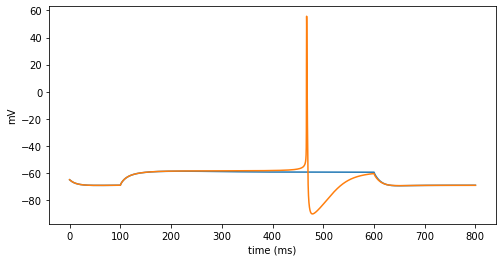

In [23]:
# One Trace
from helpers import generic
reload(generic)
generic.plotTraces([underplot,overplot])

## Plotting of the initial AP

Plots the first AP that is being genarated by the Plot

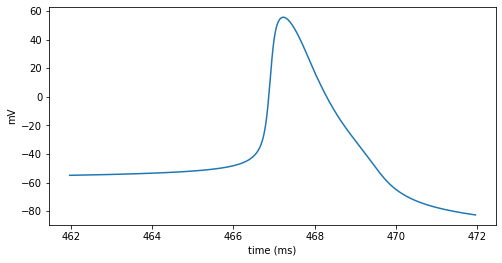

In [24]:
from helpers.generic import isolateTime, plotTrace

firstpeaktime = overplot["aps"][0]
newtrace = isolateTime(overplot, firstpeaktime)
plotTrace(newtrace)


## Calculate the Input Resistance

The input resistance si calculated by measuring the differences of the maximum voltage in the simutlation window to baseline of a 0 amp stimulus of a stimuli ranging from `i*0.1 in range(0,10)` 

In [25]:
from helpers.generic import *

inputresistances = calculateInputResistance(layer_v_with_ais_test.SPI6)
inputresistances.mean()
        

85.81489754460289

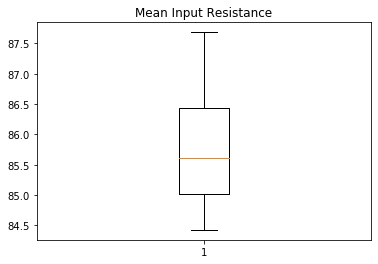

In [29]:
import numpy as np
from matplotlib import pyplot 

fig, axs = pyplot.subplots()
axs.boxplot(inputresistances)
axs.set_title("Mean Input Resistance")
pyplot.show()